In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

from fuzzywuzzy import fuzz

/usr/local/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Referenced recommendation prototype created by Kevin Liao:
https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-1-knn-item-based-collaborative-filtering-637969614ea

## Anime Data

Load anime and ratings data

In [2]:
anime_filename = '../data/anime.csv'
ratings_filename = '../data/rating.csv'

In [3]:
anime_df = pd.read_csv(anime_filename)
ratings_df = pd.read_csv(ratings_filename)

In [4]:
anime = anime_df.copy()
ratings = ratings_df.copy()

In [5]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [6]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


Dropping NaN values (only 1% of full data lost)

## Ratings Data

In [8]:
ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [9]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


Frequency of ratings

Text(0, 0.5, 'Titles')

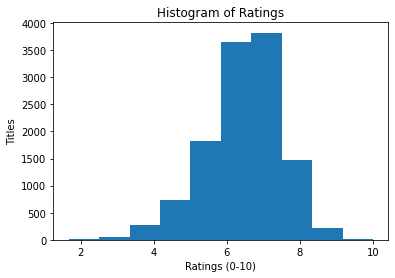

In [10]:
plt.hist(anime.rating)
plt.title("Histogram of Ratings")
plt.xlabel("Ratings (0-10)")
plt.ylabel("Titles")

Ratings by users:

In [11]:
user_ratings = ratings.groupby('user_id').size().reset_index(name='counts').sort_values(by="counts",ascending=False)
user_ratings = user_ratings.set_index('user_id')
user_ratings.head()

,counts
user_id,
48766,10227
42635,3747
53698,2905
57620,2702
59643,2633


In [17]:
user_ratings.counts.mean().round(0)

106.0

The average user in this database has rated around 106 anime titles.

Checking if there are duplicate ratings (same user rated a title multiple times):

In [12]:
ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [13]:
ratings.shape

(7813737, 3)

In [14]:
ratings.groupby(['user_id','anime_id']).size()

user_id  anime_id
1        20          1
         24          1
         79          1
         226         1
         241         1
                    ..
73515    16512       1
         17187       1
         22145       1
73516    790         1
         8074        1
Length: 7813730, dtype: int64

In [16]:
user_ratings_cnt = ratings.groupby(['user_id','anime_id']).size().reset_index() 
duplicates = user_ratings_cnt[user_ratings_cnt[0]>1]
duplicates

,user_id,anime_id,0
4499261,42653,1575,2
4499263,42653,2001,2
4499292,42653,11757,2
4499303,42653,16498,2
4499309,42653,20507,2
4499315,42653,22319,2
4499318,42653,23283,2


In [17]:
len(duplicates)

7

In [18]:
# Take the mean of duplicate ratings since there is no timestamp detail for the latest sentiment.
ratings = ratings.groupby(['user_id','anime_id']).mean().reset_index()
ratings.head()

,user_id,anime_id,rating
0,1,20,-1.0
1,1,24,-1.0
2,1,79,-1.0
3,1,226,-1.0
4,1,241,-1.0


In [19]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813730 entries, 0 to 7813729
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   user_id   int64  
 1   anime_id  int64  
 2   rating    float64
dtypes: float64(1), int64(2)
memory usage: 178.8 MB


---

### Preparing Data

Utility Matrix:

In [20]:
user_anime_mat = ratings.reset_index().pivot(
    index = 'anime_id',
    columns='user_id',
    values='rating'
)

In [21]:
user_anime_mat.fillna(0,inplace=True)

In [22]:
user_anime_mat

user_id,1,2,3,4,5,6,7,8,9,10,...,73507,73508,73509,73510,73511,73512,73513,73514,73515,73516
anime_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,10.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,10.0,0.0
6,0.0,0.0,0.0,-1.0,8.0,0.0,0.0,0.0,0.0,0.0,...,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34412,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Creating sparse matrix

In [23]:
anime_user_mat_sparse = csr_matrix(user_anime_mat.values)

In [24]:
anime_user_mat_sparse.get_shape()

(11200, 73515)

In [29]:
print(anime_user_mat_sparse[1])

  (0, 12)	-1.0
  (0, 18)	9.0
  (0, 20)	9.0
  (0, 22)	10.0
  (0, 50)	9.0
  (0, 53)	-1.0
  (0, 138)	9.0
  (0, 151)	9.0
  (0, 159)	9.0
  (0, 192)	-1.0
  (0, 199)	10.0
  (0, 218)	-1.0
  (0, 233)	9.0
  (0, 241)	8.0
  (0, 273)	-1.0
  (0, 276)	9.0
  (0, 293)	7.0
  (0, 295)	-1.0
  (0, 301)	-1.0
  (0, 305)	8.0
  (0, 331)	9.0
  (0, 338)	-1.0
  (0, 341)	-1.0
  (0, 362)	9.0
  (0, 381)	9.0
  :	:
  (0, 73373)	10.0
  (0, 73374)	8.0
  (0, 73376)	9.0
  (0, 73385)	-1.0
  (0, 73387)	7.0
  (0, 73393)	9.0
  (0, 73394)	8.0
  (0, 73406)	10.0
  (0, 73411)	9.0
  (0, 73422)	9.0
  (0, 73424)	9.0
  (0, 73425)	-1.0
  (0, 73449)	-1.0
  (0, 73455)	10.0
  (0, 73458)	9.0
  (0, 73460)	8.0
  (0, 73468)	8.0
  (0, 73478)	8.0
  (0, 73489)	-1.0
  (0, 73493)	8.0
  (0, 73501)	7.0
  (0, 73502)	10.0
  (0, 73505)	8.0
  (0, 73511)	8.0
  (0, 73513)	10.0


Creating hashmap for anime titles to match with id/index

In [30]:
anime_titles = anime[['anime_id','name']]
anime_titles

,anime_id,name
0,32281,Kimi no Na wa.
1,5114,Fullmetal Alchemist: Brotherhood
2,28977,Gintama°
3,9253,Steins;Gate
4,9969,Gintama&#039;
...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami
12290,5543,Under World
12291,5621,Violence Gekiga David no Hoshi
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...


In [31]:
# Filtered anime title name key
ind_list = list(user_anime_mat.index)
anime_titles = anime_titles.set_index('anime_id')
anime_titles

,name
anime_id,
32281,Kimi no Na wa.
5114,Fullmetal Alchemist: Brotherhood
28977,Gintama°
9253,Steins;Gate
9969,Gintama&#039;
...,...
9316,Toushindai My Lover: Minami tai Mecha-Minami
5543,Under World
5621,Violence Gekiga David no Hoshi


In [32]:
# ratings_user = ratings.merge(test_anime,left_on='anime_id',right_on='anime_id',how='inner')
# ratings_user

In [33]:
hashmap = {
    anime: i for i, anime in
    enumerate(list(anime_titles.name))
}

In [34]:
hashmap

{'Kimi no Na wa.': 0,
 'Fullmetal Alchemist: Brotherhood': 1,
 'Gintama°': 2,
 'Steins;Gate': 3,
 'Gintama&#039;': 4,
 'Haikyuu!!: Karasuno Koukou VS Shiratorizawa Gakuen Koukou': 5,
 'Hunter x Hunter (2011)': 6,
 'Ginga Eiyuu Densetsu': 7,
 'Gintama Movie: Kanketsu-hen - Yorozuya yo Eien Nare': 8,
 'Gintama&#039;: Enchousen': 9,
 'Clannad: After Story': 10,
 'Koe no Katachi': 11,
 'Gintama': 12,
 'Code Geass: Hangyaku no Lelouch R2': 13,
 'Haikyuu!! Second Season': 14,
 'Sen to Chihiro no Kamikakushi': 15,
 'Shigatsu wa Kimi no Uso': 16,
 'Mushishi Zoku Shou 2nd Season': 17,
 'Ookami Kodomo no Ame to Yuki': 18,
 'Code Geass: Hangyaku no Lelouch': 19,
 'Hajime no Ippo': 20,
 'Rurouni Kenshin: Meiji Kenkaku Romantan - Tsuioku-hen': 21,
 'Cowboy Bebop': 22,
 'One Punch Man': 23,
 'Mononoke Hime': 24,
 'Suzumiya Haruhi no Shoushitsu': 25,
 'Monogatari Series: Second Season': 26,
 'Mushishi Zoku Shou': 27,
 'Mushishi': 28,
 'Tengen Toppa Gurren Lagann': 29,
 'Great Teacher Onizuka': 30,
 '

### Implementing KNN Clustering Recommendation

In [35]:
# user will input anime title to find similar titles
fav_anime = "Naruto"

In [38]:
fuzz.ratio('haruwo','naruto')

67

In [39]:
for title,idx in hashmap.items():
    ratio = fuzz.ratio(title.lower(), fav_anime.lower())
    if ratio >= 60:
        match_tuple.append((title,idx,ratio))

In [40]:
match_tuple = sorted(match_tuple,key=lambda x: x[2])[::-1]

In [41]:
match_tuple

[('Naruto', 841, 100),
 ('Naruto', 841, 100),
 ('Naruto x UT', 1343, 71),
 ('Naruto x UT', 1343, 71),
 ('Haruwo', 7894, 67),
 ('Nayuta', 6607, 67),
 ('Nayuta', 6607, 67),
 ('Haruwo', 7894, 67)]

In [49]:
# Fuzzy matching full method

match_tuple = []
for title, idx in hashmap.items():
    ratio = fuzz.ratio(title.lower(), fav_anime.lower())
    if ratio >= 60:
        match_tuple.append((title, idx, ratio))

match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]

if not match_tuple:
    print('No match found for anime title: {0}'.format(fav_anime))
else:
    print('Found possible matches in database: {0}'.format([x[0] for x in match_tuple]))
    idx = match_tuple[0][1]
    print(idx)

Found possible matches in database: ['Naruto', 'Naruto x UT', 'Haruwo', 'Nayuta']
841


## Making Inference

In [42]:
model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

In [46]:
model.fit(anime_user_mat_sparse)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [50]:
distance,indices = model.kneighbors(anime_user_mat_sparse[idx],n_neighbors=20+1)

In [51]:
distance

array([[5.55111512e-16, 3.01692263e-01, 5.31623524e-01, 6.16461548e-01,
        7.18728987e-01, 7.44102136e-01, 7.57408343e-01, 7.58546570e-01,
        7.70684881e-01, 7.76402560e-01, 7.87160254e-01, 7.88493982e-01,
        7.88610353e-01, 7.91261758e-01, 7.93909157e-01, 7.95094713e-01,
        8.00844011e-01, 8.01414111e-01, 8.03175997e-01, 8.06650669e-01,
        8.06782182e-01]])

In [53]:
distance.squeeze()

array([5.55111512e-16, 3.01692263e-01, 5.31623524e-01, 6.16461548e-01,
       7.18728987e-01, 7.44102136e-01, 7.57408343e-01, 7.58546570e-01,
       7.70684881e-01, 7.76402560e-01, 7.87160254e-01, 7.88493982e-01,
       7.88610353e-01, 7.91261758e-01, 7.93909157e-01, 7.95094713e-01,
       8.00844011e-01, 8.01414111e-01, 8.03175997e-01, 8.06650669e-01,
       8.06782182e-01])

In [54]:
indices

array([[ 841, 2538, 2537, 2007,  840, 2379, 2796, 4294, 2364,  464, 3665,
        1903, 2059, 2119, 2499, 1856, 1882, 2836, 2134,  803, 1969]])

In [145]:
indices.squeeze()

array([ 841, 2538, 2537, 2007, 6010, 6505, 5535,  990, 2113, 6351, 7525])

In [59]:
list(zip(indices.squeeze().tolist(), distance.squeeze().tolist()))

[(841, 5.551115123125783e-16),
 (2538, 0.30169226308428043),
 (2537, 0.5316235244247207),
 (2007, 0.6164615480096997),
 (840, 0.718728986643032),
 (2379, 0.7441021358027479),
 (2796, 0.7574083430033618),
 (4294, 0.7585465700853876),
 (2364, 0.7706848807425426),
 (464, 0.7764025598704527),
 (3665, 0.7871602540950233),
 (1903, 0.788493982087065),
 (2059, 0.7886103525557383),
 (2119, 0.7912617584247648),
 (2499, 0.7939091574843622),
 (1856, 0.7950947131627021),
 (1882, 0.800844010614055),
 (2836, 0.8014141110807383),
 (2134, 0.8031759968533592),
 (803, 0.8066506693367048),
 (1969, 0.8067821823377193)]

In [62]:
# Create reverse hashmap to locate a title based on index
reverse_hashmap = {v: k for k, v in hashmap.items()}

In [63]:
reverse_hashmap[841]

'Naruto'

In [64]:
reverse_hashmap[2538]

'Wasurenagumo'

In [65]:
raw_recommends = sorted(
    list(
        zip(indices.squeeze().tolist(), distance.squeeze().tolist())
    ),
    key=lambda x: x[1])[:0:-1]

In [66]:
raw_recommends

[(1969, 0.8067821823377193),
 (803, 0.8066506693367048),
 (2134, 0.8031759968533592),
 (2836, 0.8014141110807383),
 (1882, 0.800844010614055),
 (1856, 0.7950947131627021),
 (2499, 0.7939091574843622),
 (2119, 0.7912617584247648),
 (2059, 0.7886103525557383),
 (1903, 0.788493982087065),
 (3665, 0.7871602540950233),
 (464, 0.7764025598704527),
 (2364, 0.7706848807425426),
 (4294, 0.7585465700853876),
 (2796, 0.7574083430033618),
 (2379, 0.7441021358027479),
 (840, 0.718728986643032),
 (2007, 0.6164615480096997),
 (2537, 0.5316235244247207),
 (2538, 0.30169226308428043)]

In [70]:
for a,b in enumerate(raw_recommends):
    print(a,b)

0 (1969, 0.8067821823377193)
1 (803, 0.8066506693367048)
2 (2134, 0.8031759968533592)
3 (2836, 0.8014141110807383)
4 (1882, 0.800844010614055)
5 (1856, 0.7950947131627021)
6 (2499, 0.7939091574843622)
7 (2119, 0.7912617584247648)
8 (2059, 0.7886103525557383)
9 (1903, 0.788493982087065)
10 (3665, 0.7871602540950233)
11 (464, 0.7764025598704527)
12 (2364, 0.7706848807425426)
13 (4294, 0.7585465700853876)
14 (2796, 0.7574083430033618)
15 (2379, 0.7441021358027479)
16 (840, 0.718728986643032)
17 (2007, 0.6164615480096997)
18 (2537, 0.5316235244247207)
19 (2538, 0.30169226308428043)


In [71]:
for i, (idx, dist) in enumerate(raw_recommends):
    print('{0}: {1}, with distance '
          'of {2}'.format(i+1, reverse_hashmap[idx], dist))

1: Genius Party Beyond, with distance of 0.8067821823377193
2: Shaman King, with distance of 0.8066506693367048
3: The Cockpit, with distance of 0.8031759968533592
4: Doraemon: The Day When I Was Born, with distance of 0.8014141110807383
5: Yes! Precure 5 Movie: Kagami no Kuni no Miracle Daibouken!, with distance of 0.800844010614055
6: Doraemon Movie 13: Nobita to Kumo no Oukoku, with distance of 0.7950947131627021
7: Rose of Versailles Movie, with distance of 0.7939091574843622
8: One Piece: Glorious Island, with distance of 0.7912617584247648
9: Star Driver: Kagayaki no Takuto, with distance of 0.7886103525557383
10: Maria-sama ga Miteru 4th Specials, with distance of 0.788493982087065
11: Shinmai Maou no Testament Specials, with distance of 0.7871602540950233
12: School Rumble, with distance of 0.7764025598704527
13: Genshiken Nidaime OVA, with distance of 0.7706848807425426
14: SKET Dance: SD Character Flash Anime, with distance of 0.7585465700853876
15: Lupin III: The Last Job, w